### **Data 618 Final Project**

Prediction of DSEX index using LSTM

Farhana Zahir

30 Nov 2020



#### **Description**

Stock markets have always received a lot of attention from researchers, and being able to forecast trends in the overall market can help in making investment decisions. Short term traders use a lot of technical analysis to decide on buy/sell depending on the indicators. Even long term investors focusing on fundamental analysis have to take into consideration the overall trends in the market to decide when to capture a holding. This project tries to predict the DSEX, which is the General index for the Dhaka Stock Exchange, using the Long Short Term Memory (LSTM) Network.

There have been a few studies completed along the same lines, but one study by Ding and Qin (2020) is noteworthy. Ding and Qin have used a multiple value associated model and LSTM and compares with a basic LSTM. The authors scored an accuracy of over 95%. This research will however focus on the basic LSTM model due to limited data availability.


#### **What is LSTM**

Long Short Term Memory (LSTM) networks are special kind of Recurrent Neural Network (RNN) that are capable of learning long-term dependencies. In regular RNN small weights are multiplied over and over through several time steps and the gradients diminish asymptotically to zero- a condition known as vanishing gradient problem.

LSTM network typically consists of memory blocks, referred to as cells, connected through layers. The information in the cells is contained in cell state Ct and hidden state ht and it is regulated by mechanisms, known as gates, through sigmoid and tanh activation functions.

The sigmoid function/layer outputs numbers between 0 and 1 with 0 indicating Nothing goes through and 1 implying Everything goes through. LSTM, therefore, have the ability to, conditionally, add or delete information from the cell state.

In general, the gates take in, as input, the hidden states from previous time step ht−1 and the current input xt and multiply them pointwise by weight matrices, W, and a bias b is added to the product.


#### **Methodology**

I will be following the same methodology at Dr Richard Wanjohi (http://rwanjohi.rbind.io/2018/04/05/time-series-forecasting-using-lstm-in-r/). His blog lays out a very simple approach in conducting this test. The steps are as follows:

1) Transform data to stationary

2) Use a lagged dataset

3) Split into train and test

4) Normalize the data

5) Define, compile and fit the model

6) Run Predictions and evaluate.


#### **Data Preparation**

First we load the necessary libraries. We will be using the keras library, which runs on top of tensorflow. All code is executed using the R Kernel within Jupyter Notebook.

In [96]:
#Load the necessary packages
library("keras") # for neural networks
library("tensorflow") # for machine learning
library("parallel") # for paralell computing
library("quantmod") # for financial data
library("fpp2") # for time series
library("tsbox") # for time series transformations
library("data.table") # for data manipulation
library("tidyr") # for data manipulation
library("dplyr") # for data manipulation
library(repr)
options(repr.plot.width=15, repr.plot.height=10)


Now we load the desired dataset, the values for the DSEX index. This is the Broad index for the Dhaka Stock Exchange and consists of 285 tickers (comparable to S&P500 for the US). The csv file contains Close, Open, High, Low data for each day starting 01 Jan 2015 and ending 17 Nov 2020. The data was downloaded from investing.com and is not available through any API till date. So we are reading it in using read.csv.

We have to change one column name for ease of typing. We check the header to see if the data has been read in correctly.

In [97]:
#Procedure to load desired data
DSE<-read.csv('DSEX.csv')


In [98]:
names(DSE)[names(DSE) == 'ï..Date'] <- 'Date'
head(DSE)

,Date,Close,Open,High,Low
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,2015-01-01,4941.51,4941.51,4941.51,4941.51
2,2015-01-05,4926.40,4926.40,4926.40,4926.40
3,2015-01-06,4969.67,4969.67,4969.67,4969.67
4,2015-01-07,4963.66,4963.66,4963.66,4963.66
5,2015-01-08,4968.71,4968.71,4968.71,4968.71
6,2015-01-11,4943.99,4943.99,4943.99,4943.99


The date column has been read in as a character, so we change it to date format, as we will be converting this to an xts object.

In [99]:
#Convert to Date
DSE$Date<-as.Date(DSE$Date)
str(DSE)

'data.frame':	1391 obs. of  5 variables:
 $ Date : Date, format: "2015-01-01" "2015-01-05" ...
 $ Close: num  4942 4926 4970 4964 4969 ...
 $ Open : num  4942 4926 4970 4964 4969 ...
 $ High : num  4942 4926 4970 4964 4969 ...
 $ Low  : num  4942 4926 4970 4964 4969 ...


We convert the dataframe into xts. We exclude the first column (Date) and convert the object by ordering it using the data. Hence we create a time series object from our dataframe.

In [100]:
DSE <- xts(DSE[,-1], order.by=DSE[,1])
str(DSE)

An 'xts' object on 2015-01-01/2020-11-17 containing:
  Data: num [1:1391, 1:4] 4942 4926 4970 4964 4969 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:4] "Close" "Open" "High" "Low"
  Indexed by objects of class: [Date] TZ: UTC
  xts Attributes:  
 NULL


In [101]:
#Check the class
class(DSE)

[1] "xts" "zoo"

#### **Data Visualization**

Let us plot the index first using chartSeries from quantmod. We see a declining trend after 2017, exacerbated by the Covid affect. However the index seems to be regaining in recent times. There is a lot of volatility involved, and it will be interesting to see if LSTM can predict this correctly.

The histogram below shows a bimodal distribution, perhaps a regime change after the crash of 2017.

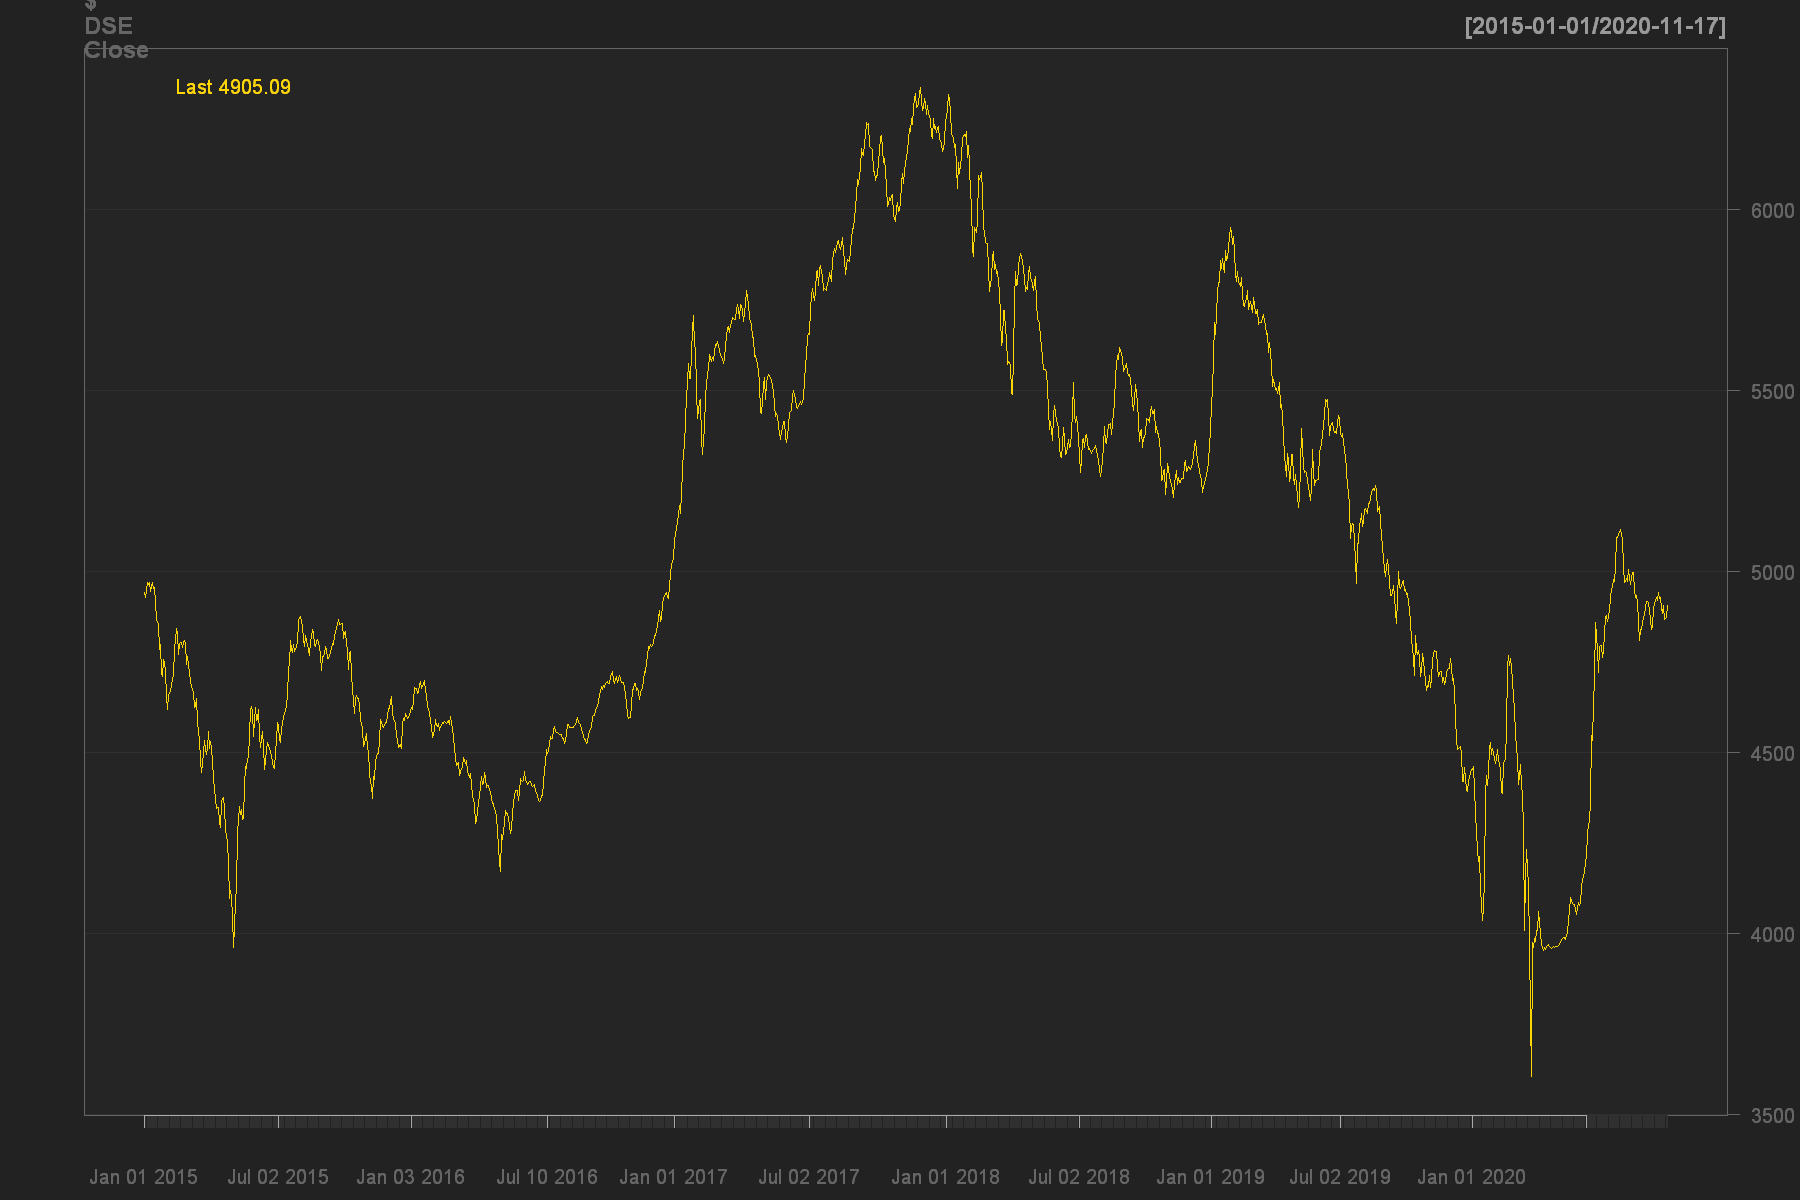

In [102]:
chartSeries(DSE$Close, type="line",
            theme = chartTheme("black", up.col='gold'), 
            main= 'DSEX')

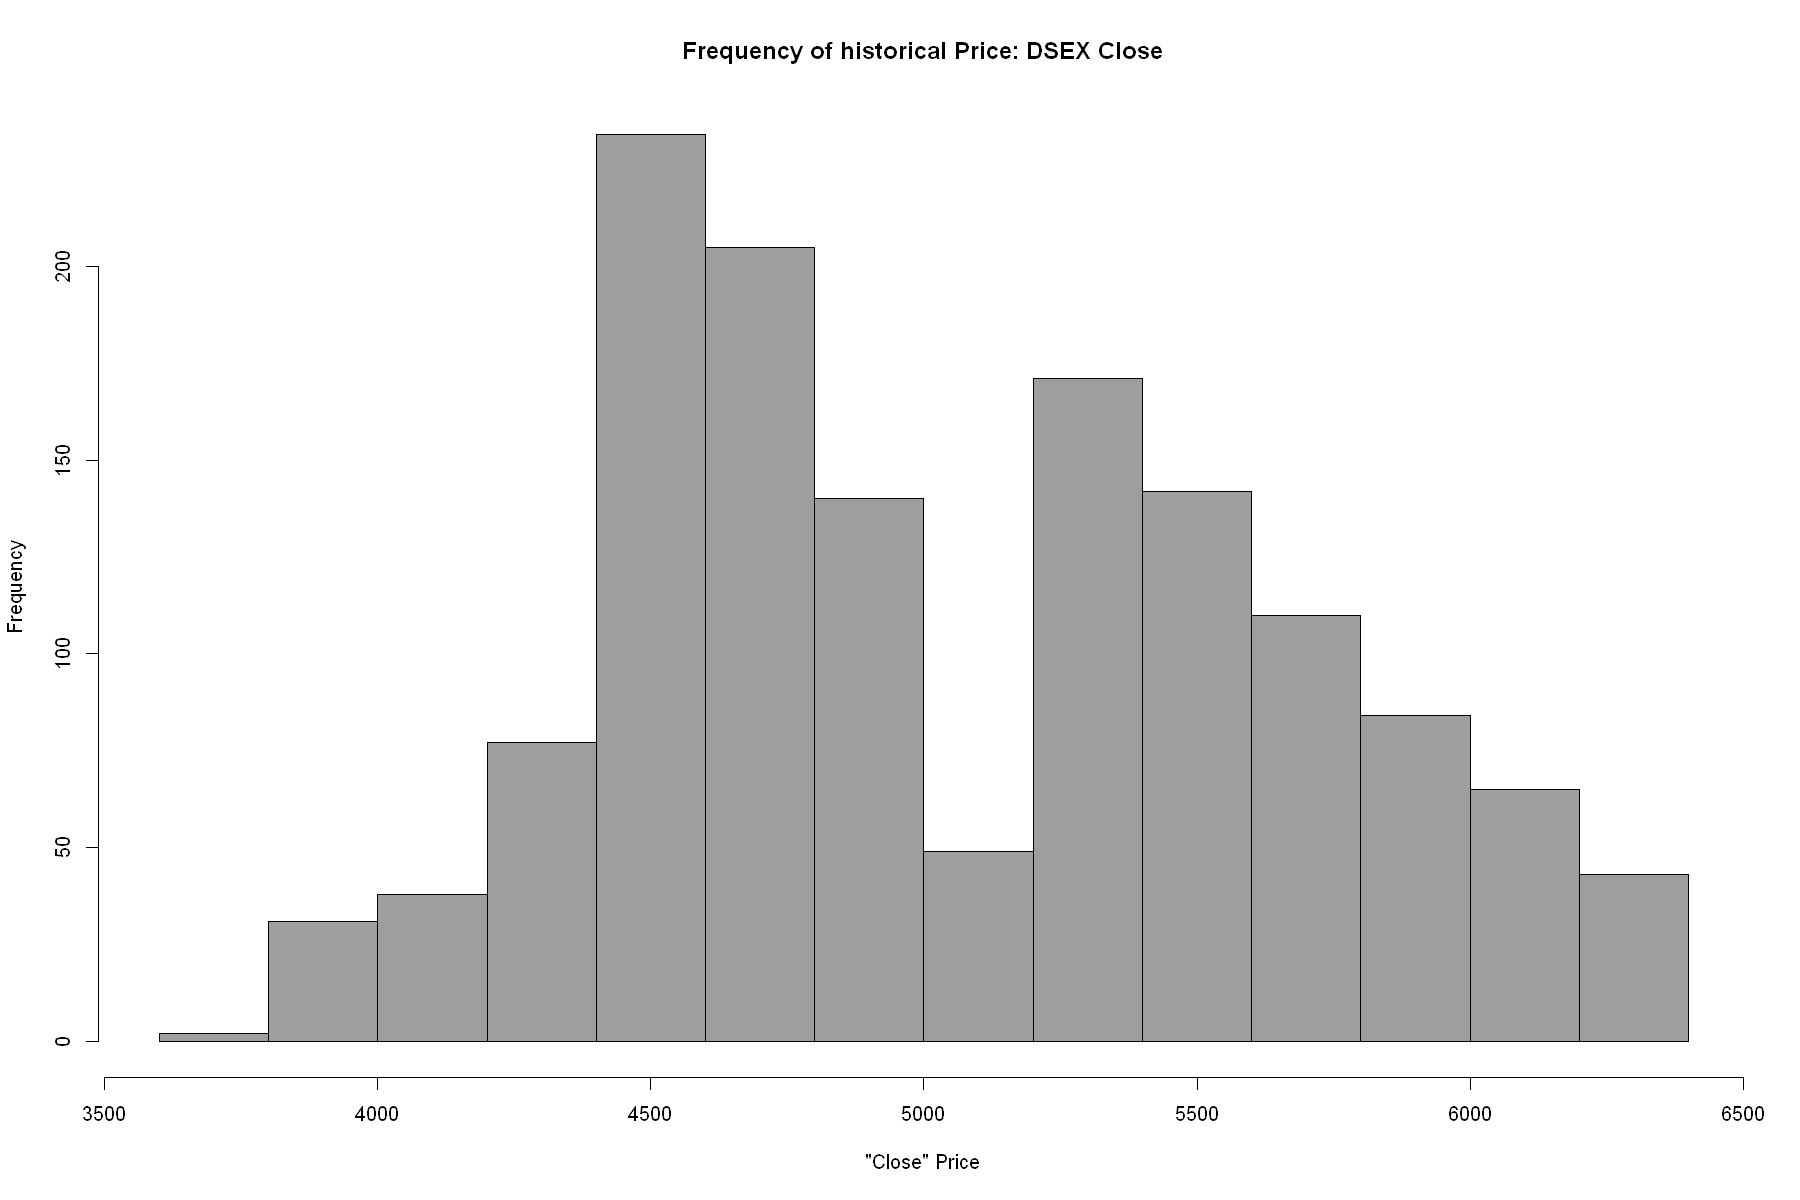

In [103]:
hist(DSE$Close,
main = 'Frequency of historical Price: DSEX Close',
xlab = '"Close" Price',
col = 8)

In [104]:
summary(DSE)

     Index                Close           Open           High     
 Min.   :2015-01-01   Min.   :3604   Min.   :3604   Min.   :3845  
 1st Qu.:2016-06-03   1st Qu.:4580   1st Qu.:4580   1st Qu.:4581  
 Median :2017-11-07   Median :4944   Median :4944   Median :4955  
 Mean   :2017-11-14   Mean   :5068   Mean   :5068   Mean   :5072  
 3rd Qu.:2019-04-10   3rd Qu.:5529   3rd Qu.:5529   3rd Qu.:5529  
 Max.   :2020-11-17   Max.   :6337   Max.   :6337   Max.   :6337  
      Low      
 Min.   :3593  
 1st Qu.:4579  
 Median :4942  
 Mean   :5065  
 3rd Qu.:5529  
 Max.   :6337  

We can look at the returns also. We are calculating log returns for this purpose.Again, we see a spike in volatility during feb-may 2020, the Covid effect. The return distribution is unimodal with a very high concentration within +/- 0.01%.

In [105]:
DSE_return<-periodReturn(DSE[,'Close'], period='daily', type='log', leading=TRUE)
head(DSE_return)

           daily.returns
2015-01-01   0.000000000
2015-01-05  -0.003062454
2015-01-06   0.008744941
2015-01-07  -0.001210068
2015-01-08   0.001016877
2015-01-11  -0.004987552

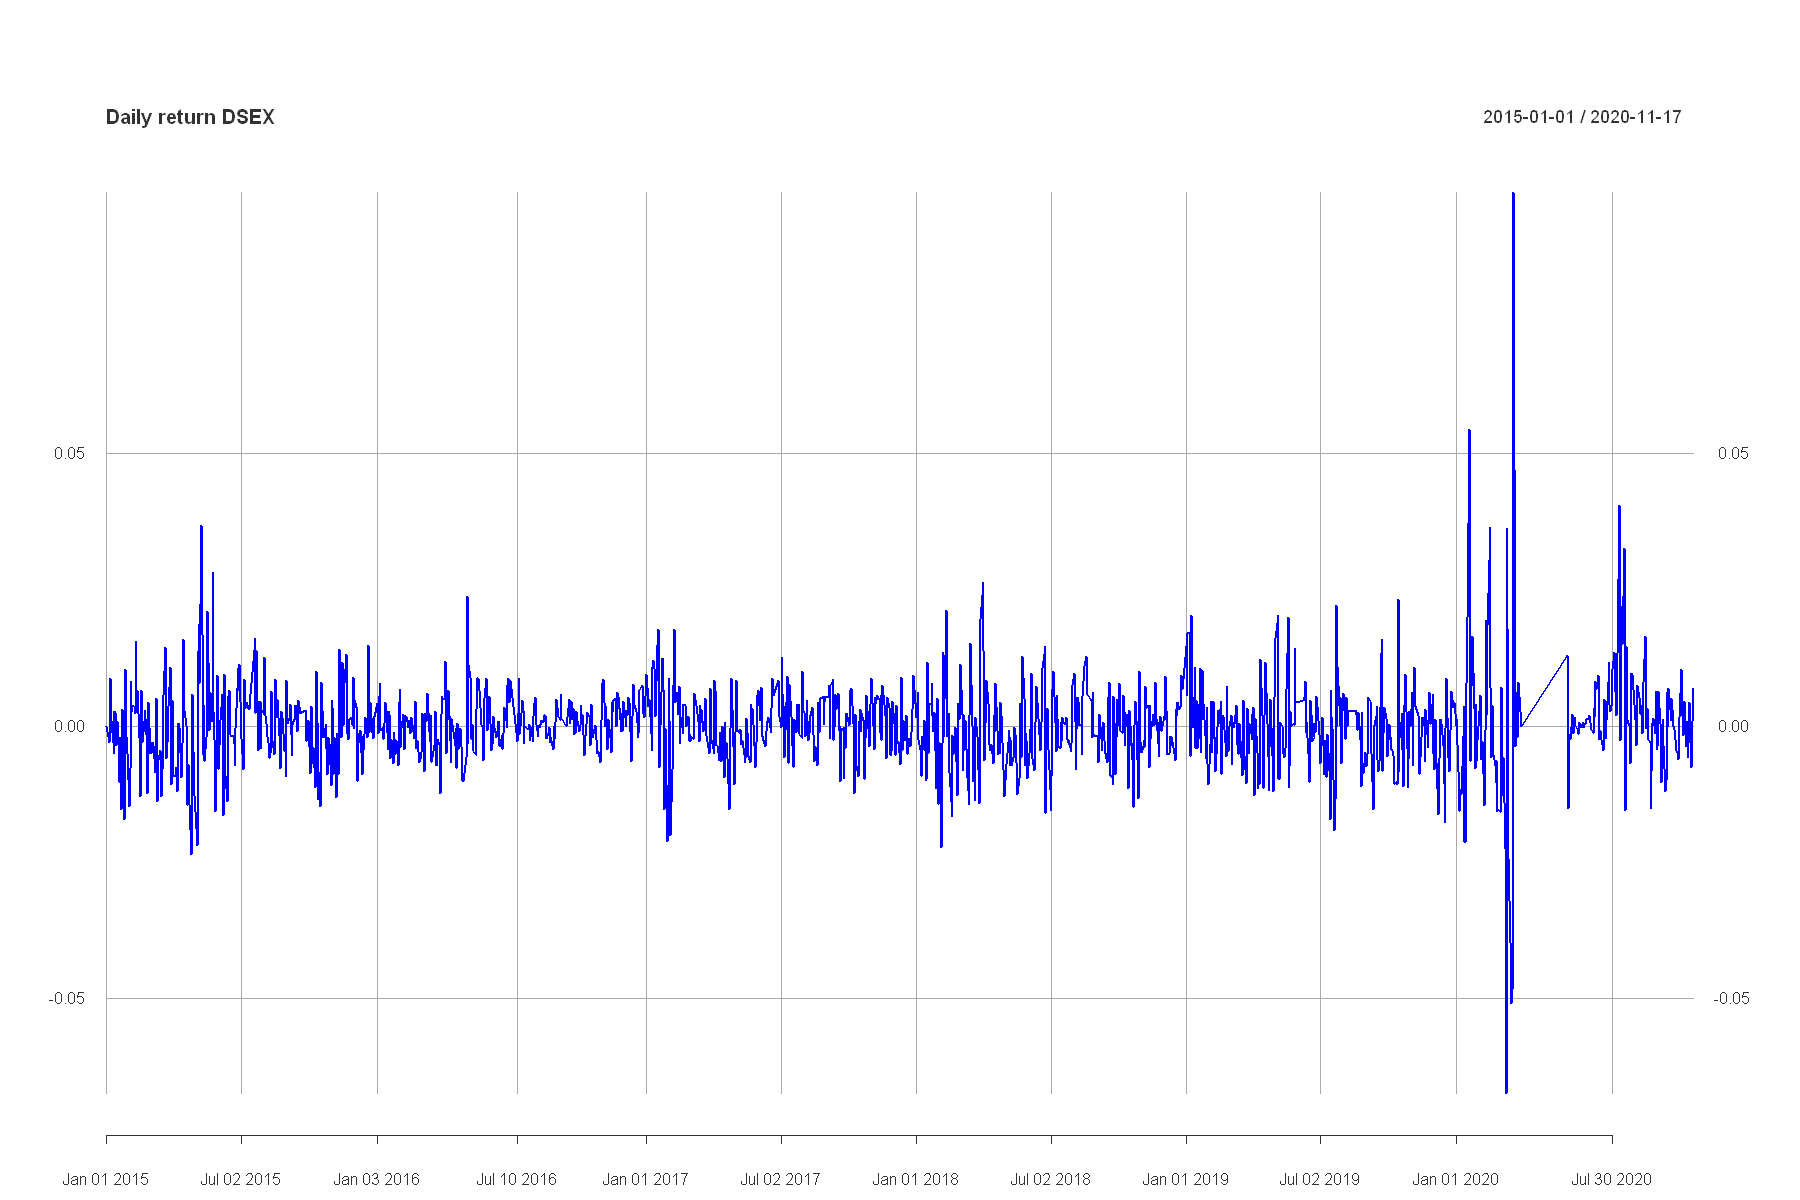

In [106]:
plot(DSE_return$daily.returns,
main = 'Daily return DSEX',
col = 'blue')

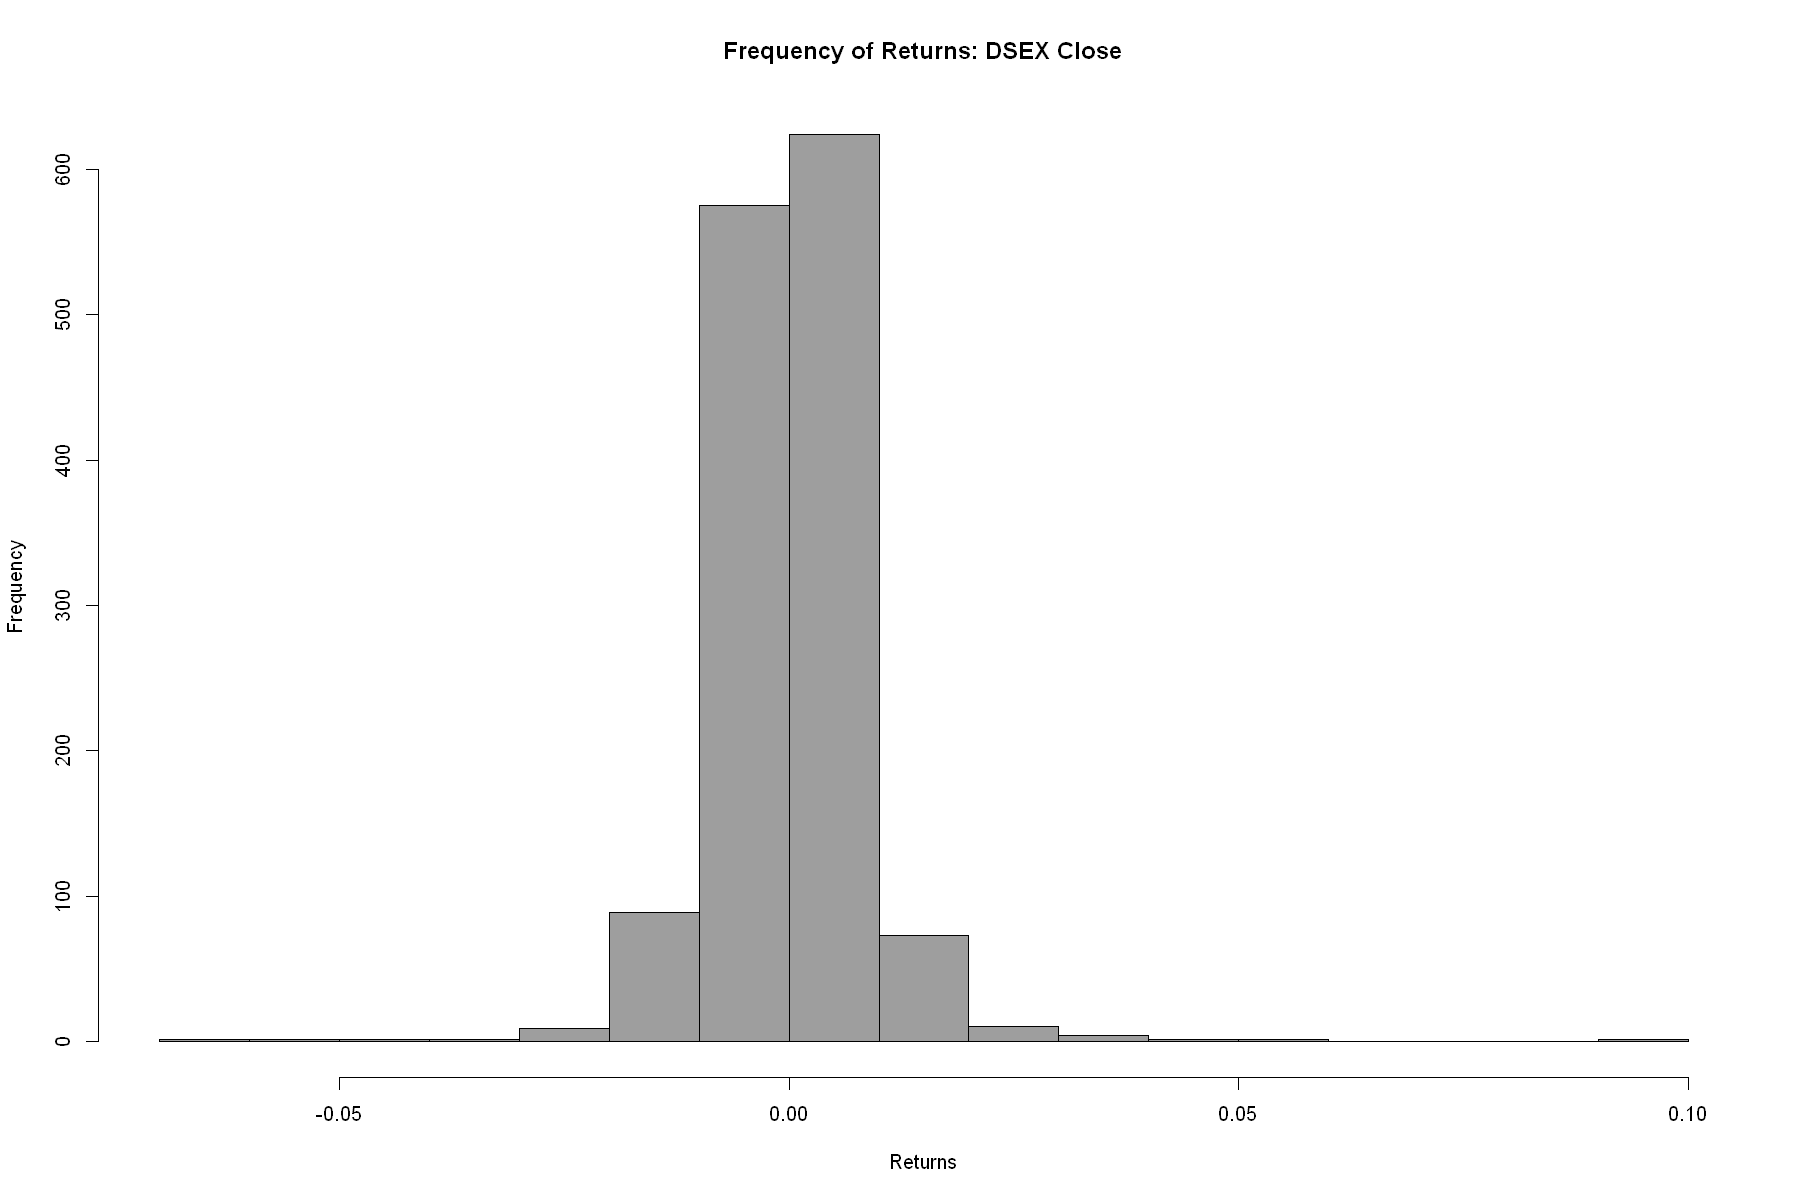

In [107]:
hist(DSE_return,
main = 'Frequency of Returns: DSEX Close',
xlab = 'Returns',
col = 8)

#### **Transform data to stationary and introduce lag**

We will be getting the difference between two consecutive values in the series. This methos, known as differencing, removes components that are time dependent.LTSM expects the data to be in the form of a target variable and predictor variable. To achieve this, we transform the series by lagging the series and have the value at time (t−k) as the input and value at time t as the ouput, for a k-step lagged dataset. We are using a lag of 1 as that gives us the highest correlation.


In [108]:
#Procedure to find daily closing price difference from previous trading day.
daily.diff <- diff(DSE$Close, differences = 1)
series <- tsbox::ts_ts(daily.diff)
# Naming column as "t-1".
colnames(daily.diff) <- 't-1'
# Assigning Zero to first NA Value.
daily.diff$`t-1`[1] <- 0
daily.diff$`t` <- shift(daily.diff$`t-1`, n=1, fill=0, type="lead")
#Source: http://rwanjohi.rbind.io/2018/04/05/time-series-forecasting-using-lstm-in-r/

In [109]:
# Procedure to visualize new time series based on one lag.
series <- ts_df(daily.diff)
series <- ts_wide(series)
colnames(series) <- c("time","t-1","t")
#Source: http://rwanjohi.rbind.io/2018/04/05/time-series-forecasting-using-lstm-in-r/

head(series)

,time,t-1,t
,<date>,<dbl>,<dbl>
1,2015-01-01,0.00,-15.11
2,2015-01-05,-15.11,43.27
3,2015-01-06,43.27,-6.01
4,2015-01-07,-6.01,5.05
5,2015-01-08,5.05,-24.72
6,2015-01-11,-24.72,12.93


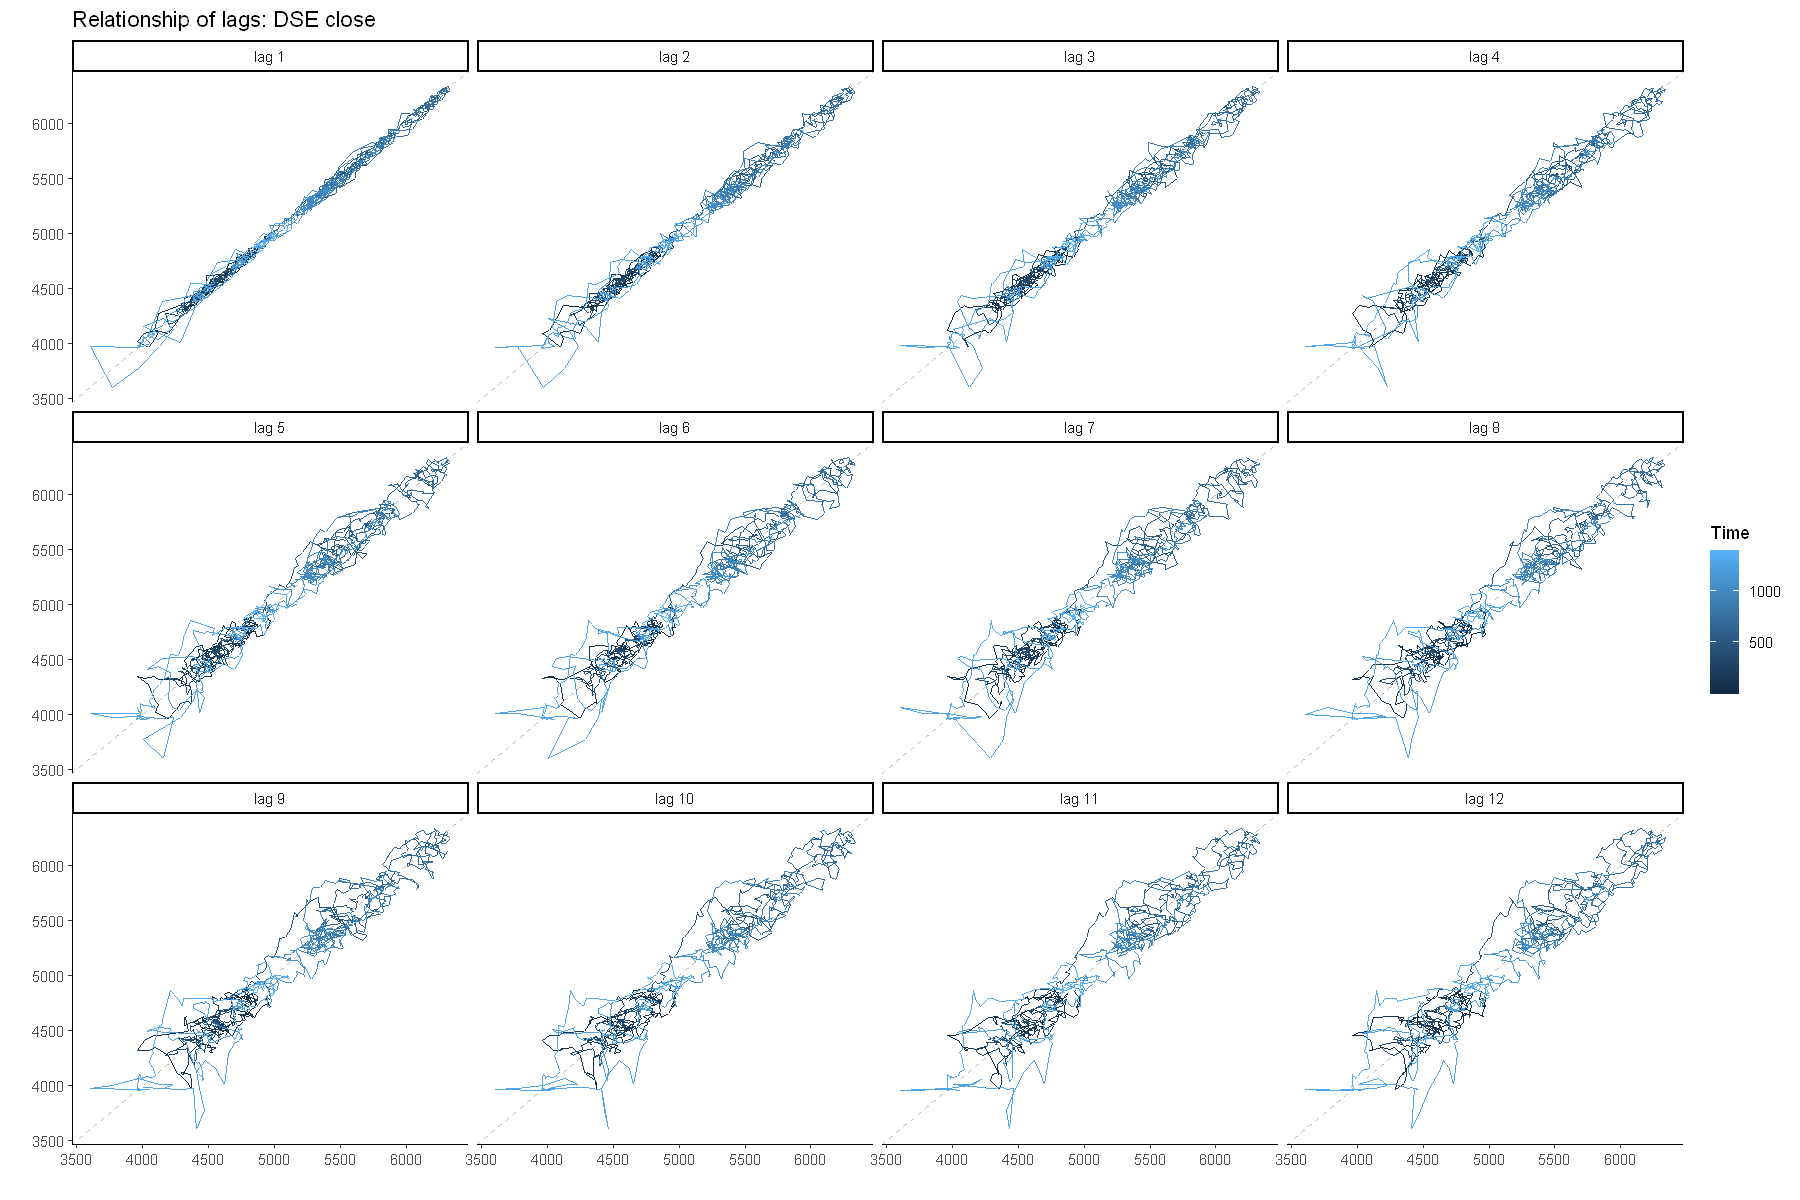

In [110]:
#Visualize lag plots
gglagplot(ts(DSE$Close), lags=12,
main = "Relationship of lags: DSE close ") +
theme_classic()
#Source: http://rwanjohi.rbind.io/2018/04/05/time-series-forecasting-using-lstm-in-r/

Warning message:
"Ignoring unknown parameters: main"


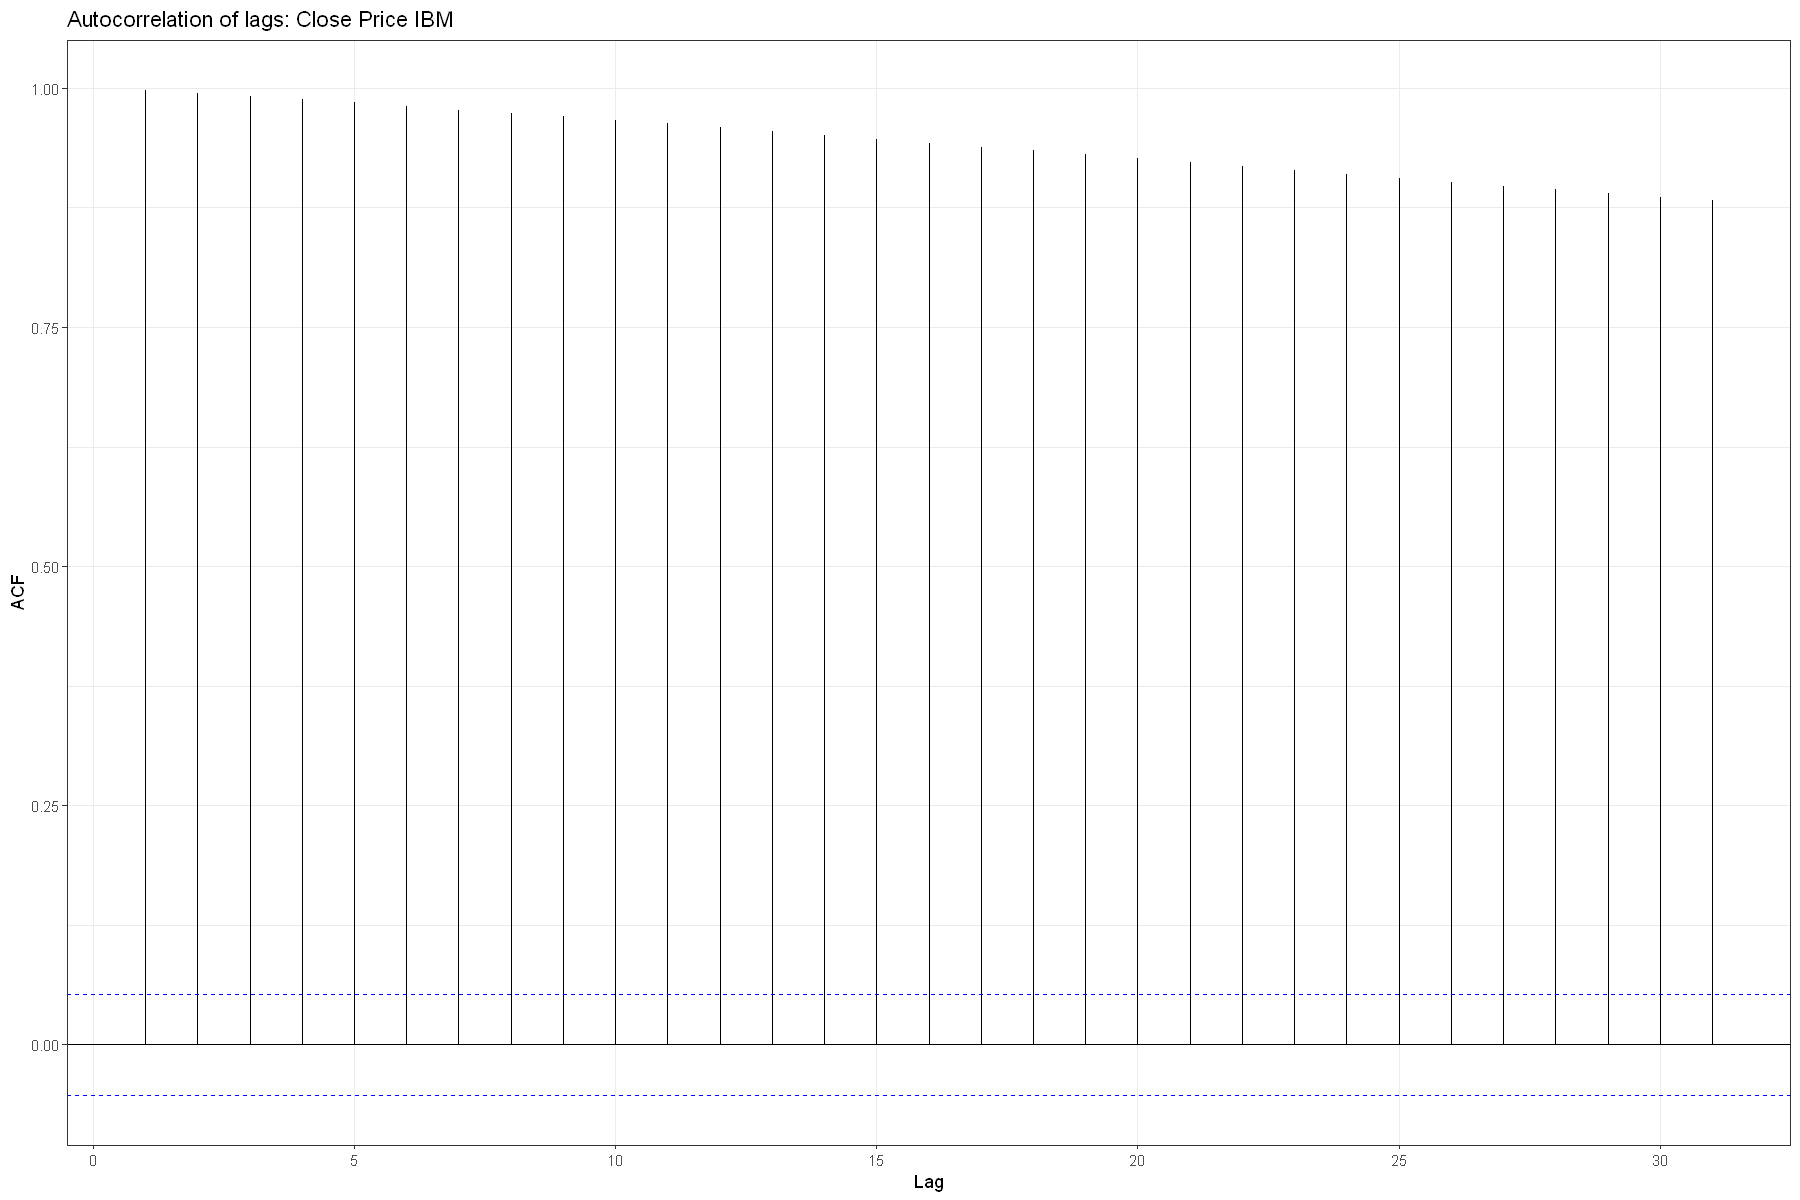

In [111]:
ggAcf(ts(DSE$Close),
main = "Autocorrelation of lags: Close Price IBM") +
theme_bw()
#http://rwanjohi.rbind.io/2018/04/05/time-series-forecasting-using-lstm-in-r/

In [112]:
#Procedure to display numerical autocorrelations by lag.
ggAcf(ts(DSE$Close), plot=FALSE)


Autocorrelations of series 'ts(DSE$Close)', by lag

    0     1     2     3     4     5     6     7     8     9    10    11    12 
1.000 0.998 0.995 0.992 0.989 0.985 0.981 0.977 0.974 0.970 0.967 0.963 0.959 
   13    14    15    16    17    18    19    20    21    22    23    24    25 
0.955 0.951 0.947 0.943 0.939 0.935 0.931 0.926 0.922 0.918 0.914 0.910 0.906 
   26    27    28    29    30    31 
0.902 0.898 0.894 0.890 0.886 0.883 

#### **Split into train and test**

We cannot split the dataset randomly in this case as the order of observations matter. We are using the first 80% values for train and the last 20% for test datasets.

In [113]:
# Split into 80% train and 20% test sets
N = nrow(series)
n = round(N * 0.8, digits = 0)
train = series[1:n, ]
test = series[(n+1):N, ]
row.names(train) <- train$time
row.names(test) <- test$time
train <- train[,-1]
test <- test[,-1]

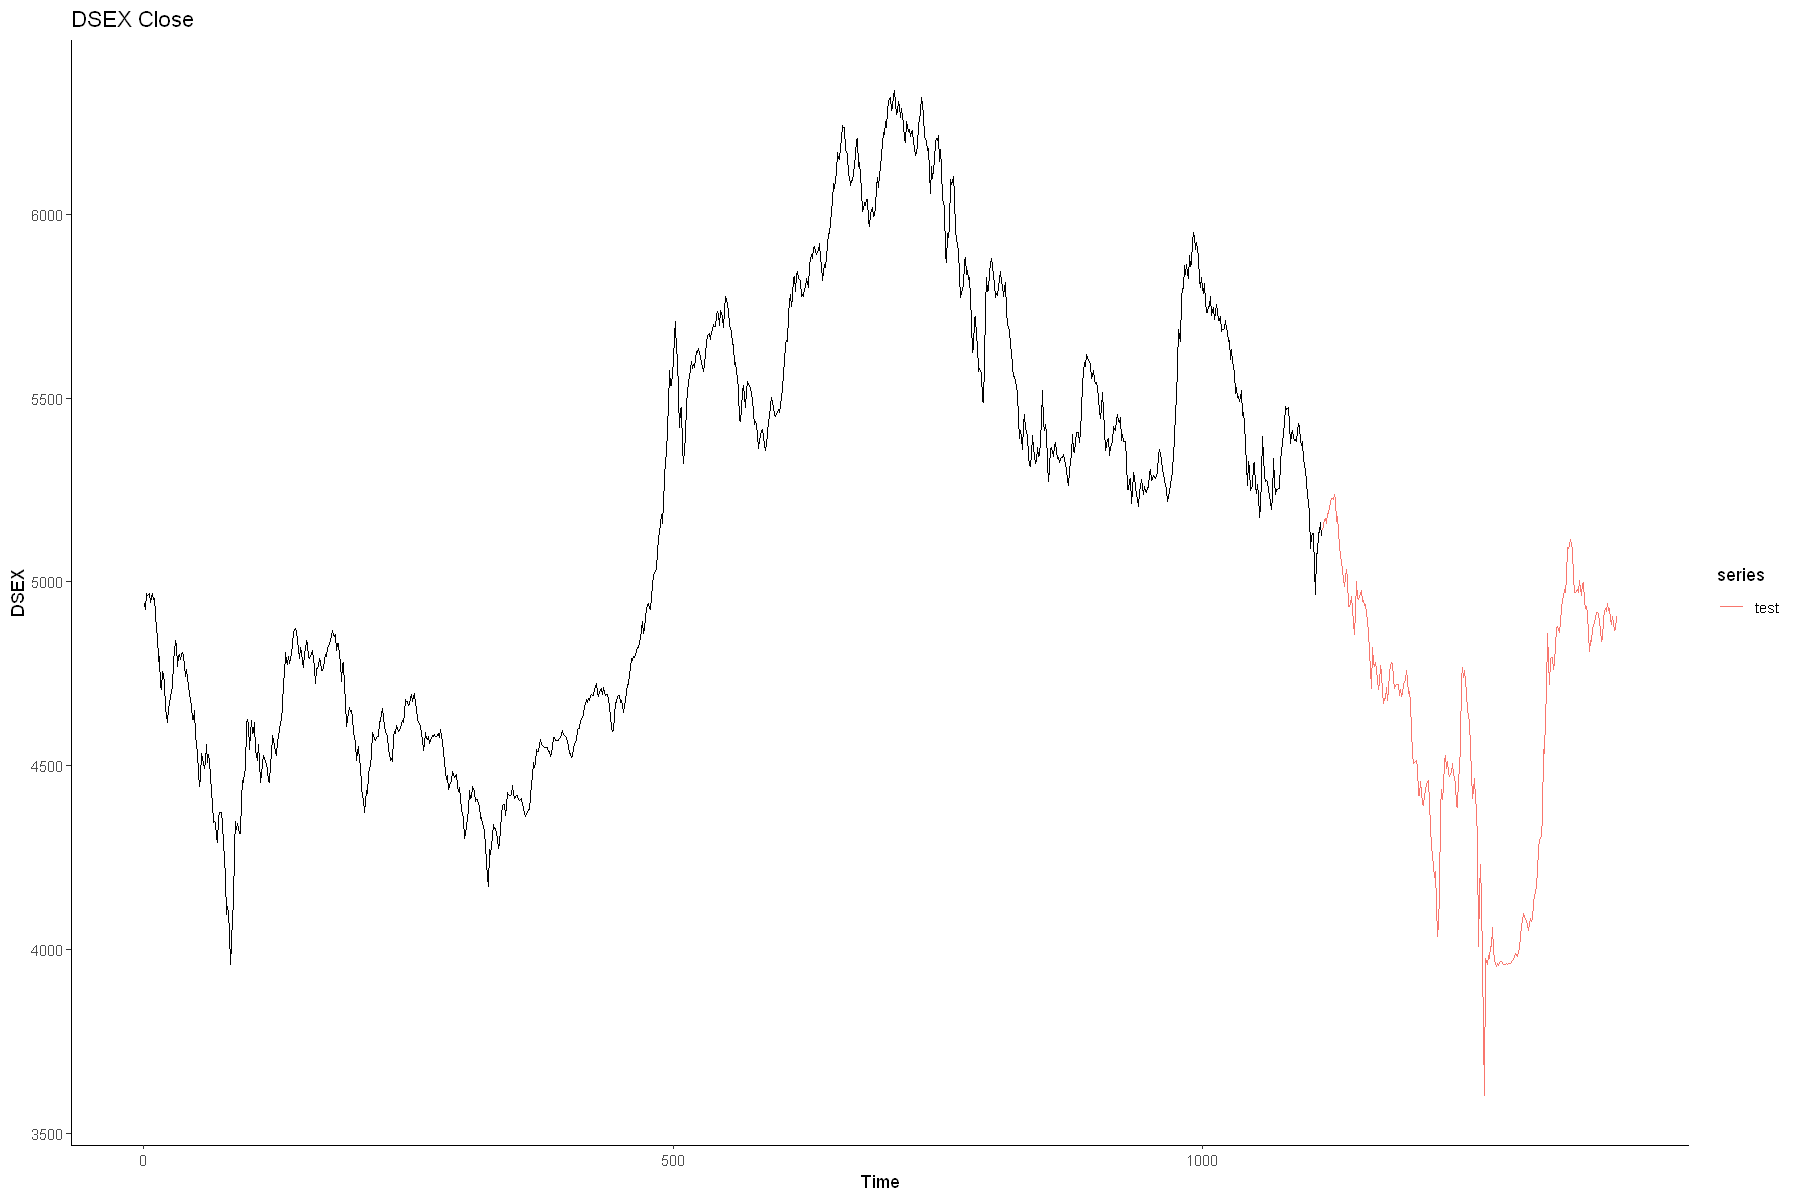

In [115]:
#Plot training data and test Original data sets.
DSE.train.ts <- DSE$Close[1:n]
DSE.test.ts <- DSE$Close[(n+1):N]
# Need to transform to times series.
DSE.train.ts <- ts(DSE.train.ts, start = 1, end = n)
DSE.test.ts <- ts(DSE.test.ts, start = n+1, end = N)
# Plotting training and test data sets.
autoplot(DSE.train.ts) +
autolayer(DSE.test.ts, series="test") +
xlab("Time") +
ylab("DSEX") +
ggtitle("DSEX Close") +
theme_classic()

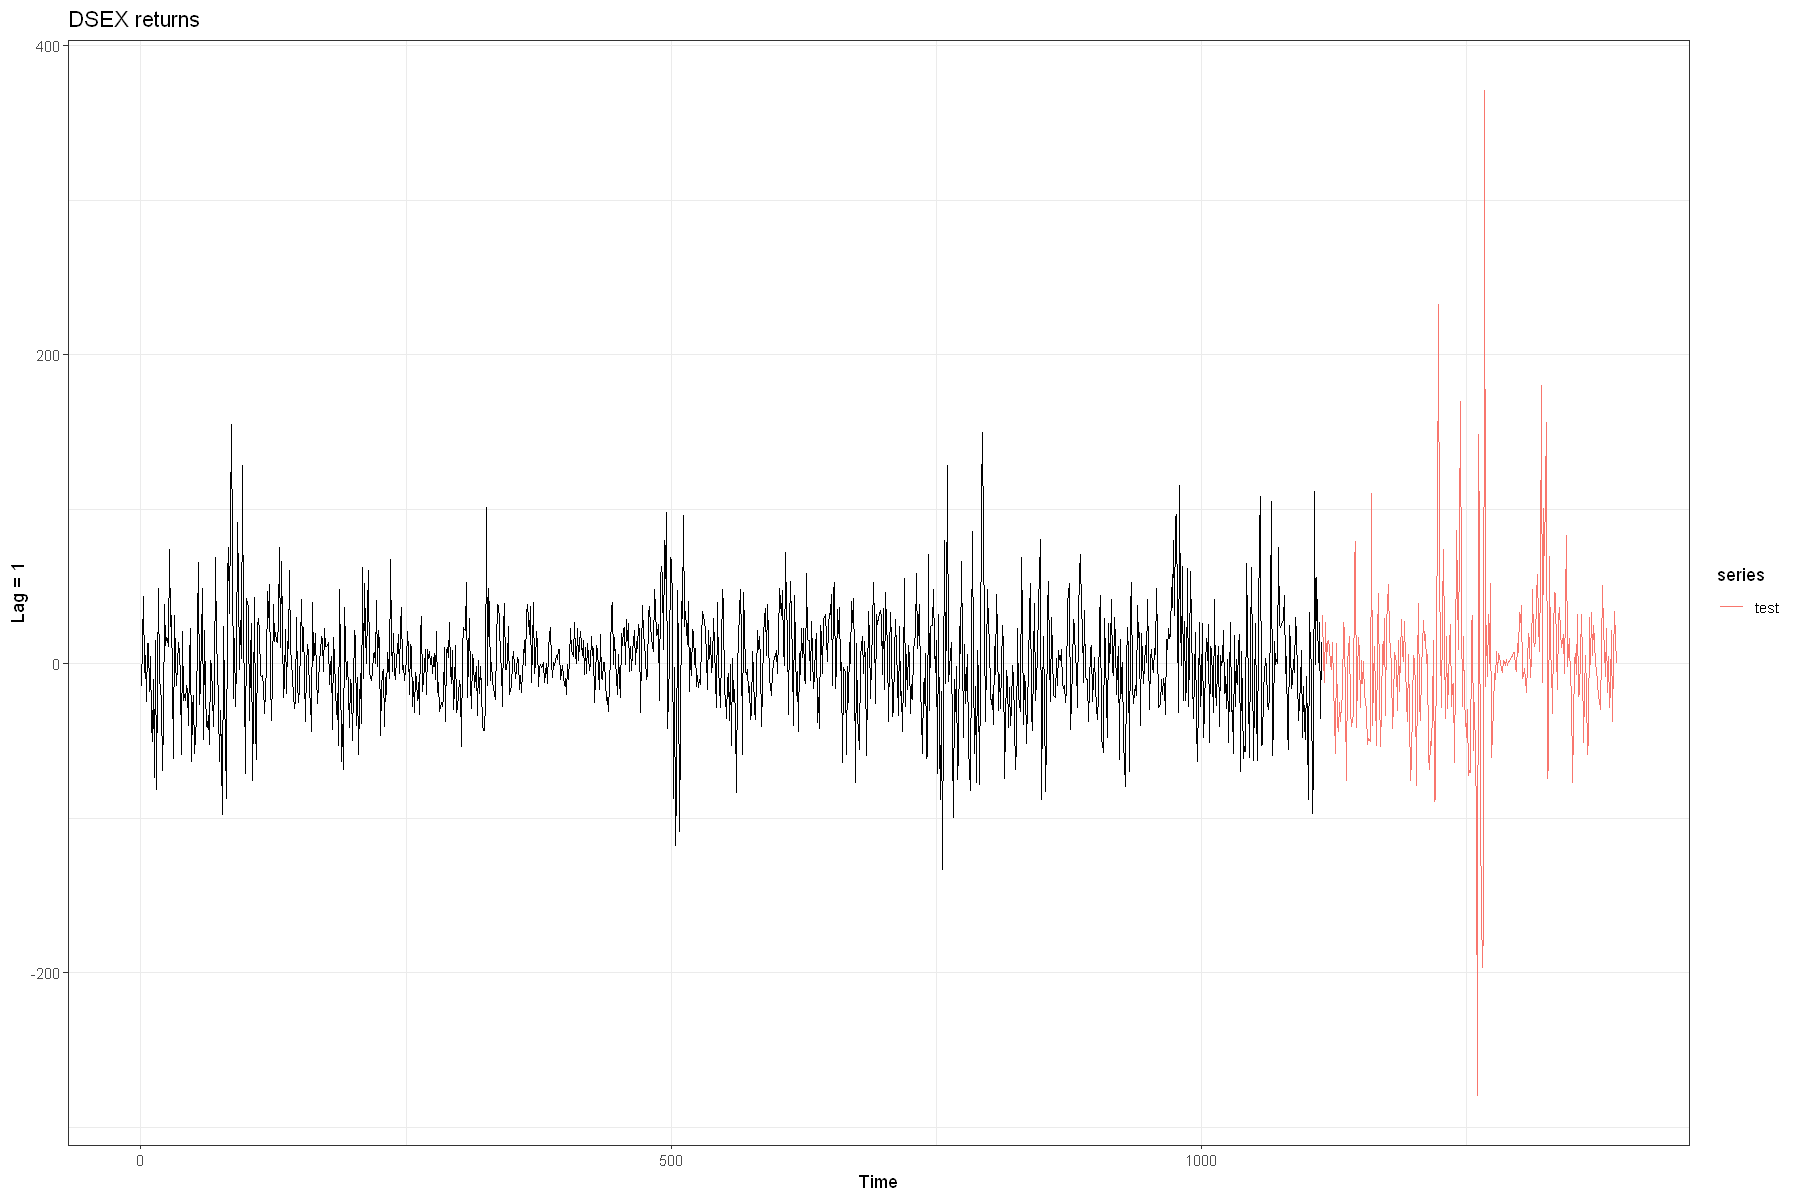

In [116]:
#Plot training data and test lags data sets.
train.ts <- ts(train, start = 1)
test.ts <- ts(test, start = n+1)
autoplot(train.ts[,"t"]) +
autolayer(test.ts[,"t"], series="test") +
xlab("Time") +
ylab("Lag = 1") +
ggtitle("DSEX returns") +
theme_bw()

 #### **Normalize the data**

LSTM uses the sigmoid function which is in the range of [-1,1].The code below will help in this transformation. Note that the min and max values of the training data set are the scaling coefficients used to scale both the training and testing data sets as well as the predicted values. This ensures that the min and max values of the test data do not influence the model.

The second part of the code, the invert function, will transform the values back to non-normalized (Original Scale).

In [117]:
#Function to obtain the MinMaxScaler for the training and test data sets.
MinMaxScaler_get = function(train, test, feature_range = c(0, 1)) {
x = train
fr_min = feature_range[1]
fr_max = feature_range[2]
std_train = ((train - min(x) ) / (max(x) - min(x) ))
std_test = ((test - min(x) ) / (max(x) - min(x) ))
scaled_train = std_train *(fr_max - fr_min) + fr_min
scaled_test = std_test *(fr_max - fr_min) + fr_min
return( list(scaled_train = as.vector(scaled_train),
scaled_test = as.vector(scaled_test),
scaler= c(min =min(x), max = max(x))) )
    }
# Extracting the normalization feature.
Scaled = MinMaxScaler_get(train, test, c(-1, 1))
y_train = Scaled$scaled_train[, 2]
x_train = Scaled$scaled_train[, 1]
y_test = Scaled$scaled_test[, 2]
x_test = Scaled$scaled_test[, 1]

#Source: http://rwanjohi.rbind.io/2018/04/05/time-series-forecasting-using-lstm-in-r/

In [118]:
# Procedure to invert the MinMaxScaler for the training and test data sets.
MinMaxScaler_invert = function(scaled, scaler, feature_range = c(0, 1)){
min = scaler[1]
max = scaler[2]
t = length(scaled)
mins = feature_range[1]
    maxs = feature_range[2]
inverted_dfs = numeric(t)
for( i in 1:t){
X = (scaled[i]- mins)/(maxs - mins)
rawValues = X *(max - min) + min
inverted_dfs[i] <- rawValues
}
return(inverted_dfs)
}
#Source: http://rwanjohi.rbind.io/2018/04/05/time-series-forecasting-using-lstm-in-r/

#### **The Model**

We will provide the input batch in a 3 dimensional array of the form [samples,timesteps,features] from the current [samples,features], where:

Samples: Number of observations in each batch, also known as the batch size.

Timesteps: Separate time steps for a given observations. In this example the timesteps = 1

Features: For a univariate case, like in this example, the features = 1

This means that the input layer expects a 3D array of data when fitting the model and when making predictions, even if specific dimensions of the array contain a single value, e.g. one sample or one feature.

When defining the input layer of your LSTM network, the network assumes you have 1 or more samples and requires that you specify the number of time steps and the number of features.

In [119]:
#the input to 3-dim
dim(x_train) <- c(length(x_train), 1, 1)
# specify required arguments

X_shape2 = dim(x_train)[2]
X_shape3 = dim(x_train)[3]
batch_size = 1
units = 1

In [120]:
# Using keras_model_sequential()
model<-keras_model_sequential()
model%>%
    layer_lstm(units, batch_input_shape=c(batch_size, X_shape2, X_shape3), stateful=TRUE)%>%
    layer_dense(units=1)

In [121]:
# Compile the model
model %>% compile(
loss = 'mean_squared_error',
optimizer = optimizer_adam( lr= 0.02, decay = 1e-6 ),
metrics = c('accuracy')
)

In [122]:
#summary results from a sequential keras model.
summary(model)

Model: "sequential_1"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
lstm_1 (LSTM)                       (1, 1)                          12          
________________________________________________________________________________
dense_1 (Dense)                     (1, 1)                          2           
Total params: 14
Trainable params: 14
Non-trainable params: 0
________________________________________________________________________________


In [123]:
#fit the LSTM model
#We set the argument shuffle = FALSE to avoid shuffling the training set and maintain the dependencies between xi and xi+t.
#LSTM also requires resetting of the network state after each epoch. To achive this we run a loop over epochs where within 
#each epoch we fit the model and reset the states via the argument reset_states().
Epochs = 50
for(i in 1:Epochs ){
model %>% fit(x_train, y_train, epochs=1, batch_size=batch_size, verbose=1,shuffle=FALSE)
model %>% reset_states()
    }

In [124]:
# Get predictions
L = length(x_test)
scaler = Scaled$scaler
predictions = numeric(L)
#Create test Series
test.Series <- data.frame(DSE.test.ts)
test.Series$Prediction <- NULL
row.names(test.Series) <- row.names(test)
for(i in 1:L){
X = x_test[i]
dim(X) = c(1,1,1)
yhat = model %>% predict(X, batch_size=batch_size)
# invert MinMaxScaler
yhat = MinMaxScaler_invert(yhat, scaler, c(-1, 1))
# invert differencing
test.Series$Prediction[i] = yhat + test.Series$Close[i]
    }

#### **Evaluate the model**

We are calculating the residuals as the difference between actual and predicted prices. The following table shows the residuals. It looks like the residuals are mostly on the positive side, with predicted values being higher than actual values. This is not a good statistic for a model and implies overfitting.

In [125]:
# Obtain predictions and errors.
test.Series$Residual <- test.Series$Close - test.Series$Prediction
test.Series

,Close,Prediction,Residual
,<dbl>,<dbl>,<dbl>
2019-07-31,5138.79,5129.764,9.025544
2019-08-01,5169.73,5162.367,7.362810
2019-08-04,5172.86,5158.707,14.152554
2019-08-05,5160.37,5144.422,15.947768
2019-08-06,5187.29,5180.882,6.408376
2019-08-07,5187.20,5172.081,15.118806
2019-08-08,5201.42,5192.729,8.690652
2019-08-18,5216.53,5206.261,10.268941
2019-08-19,5227.26,5216.375,10.885061


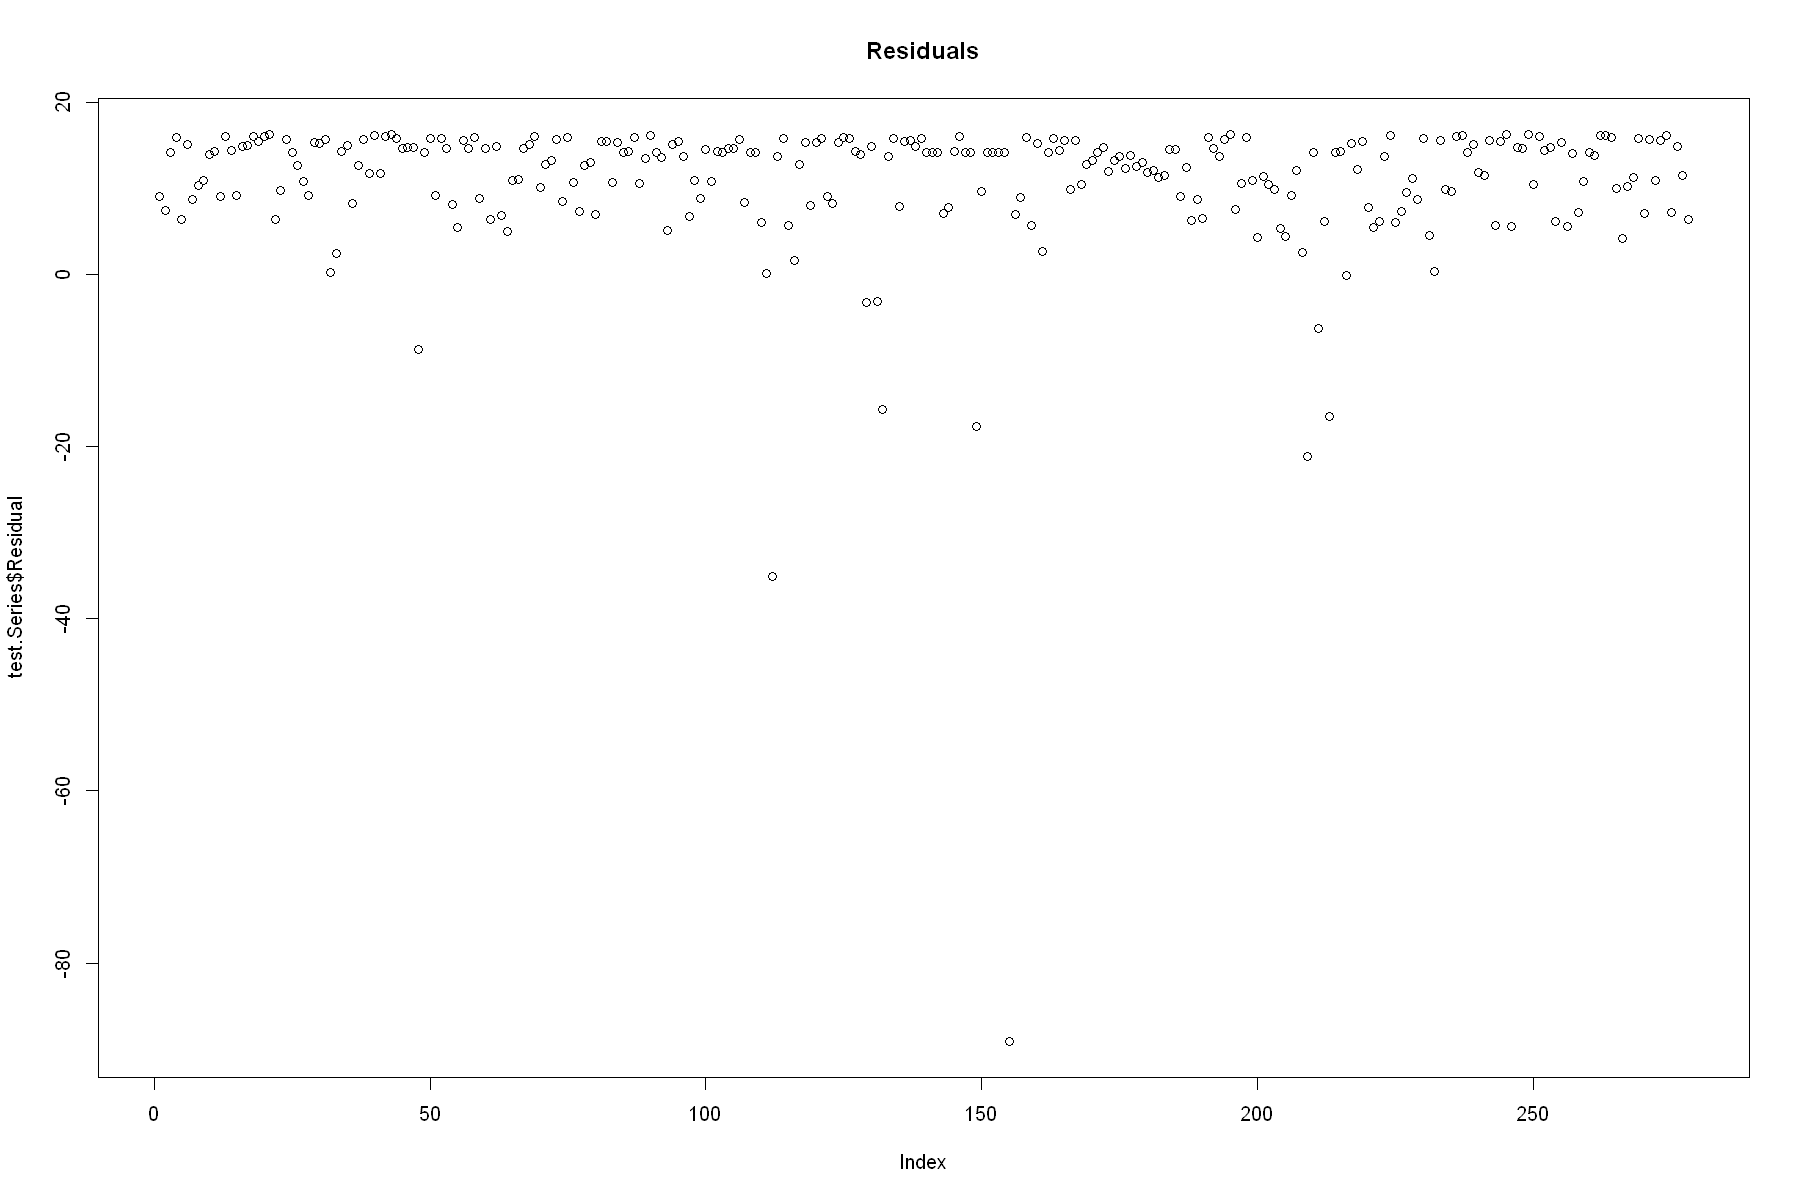

In [126]:
plot(test.Series$Residual, main='Residuals')

#### **Visualize actual and predicted**

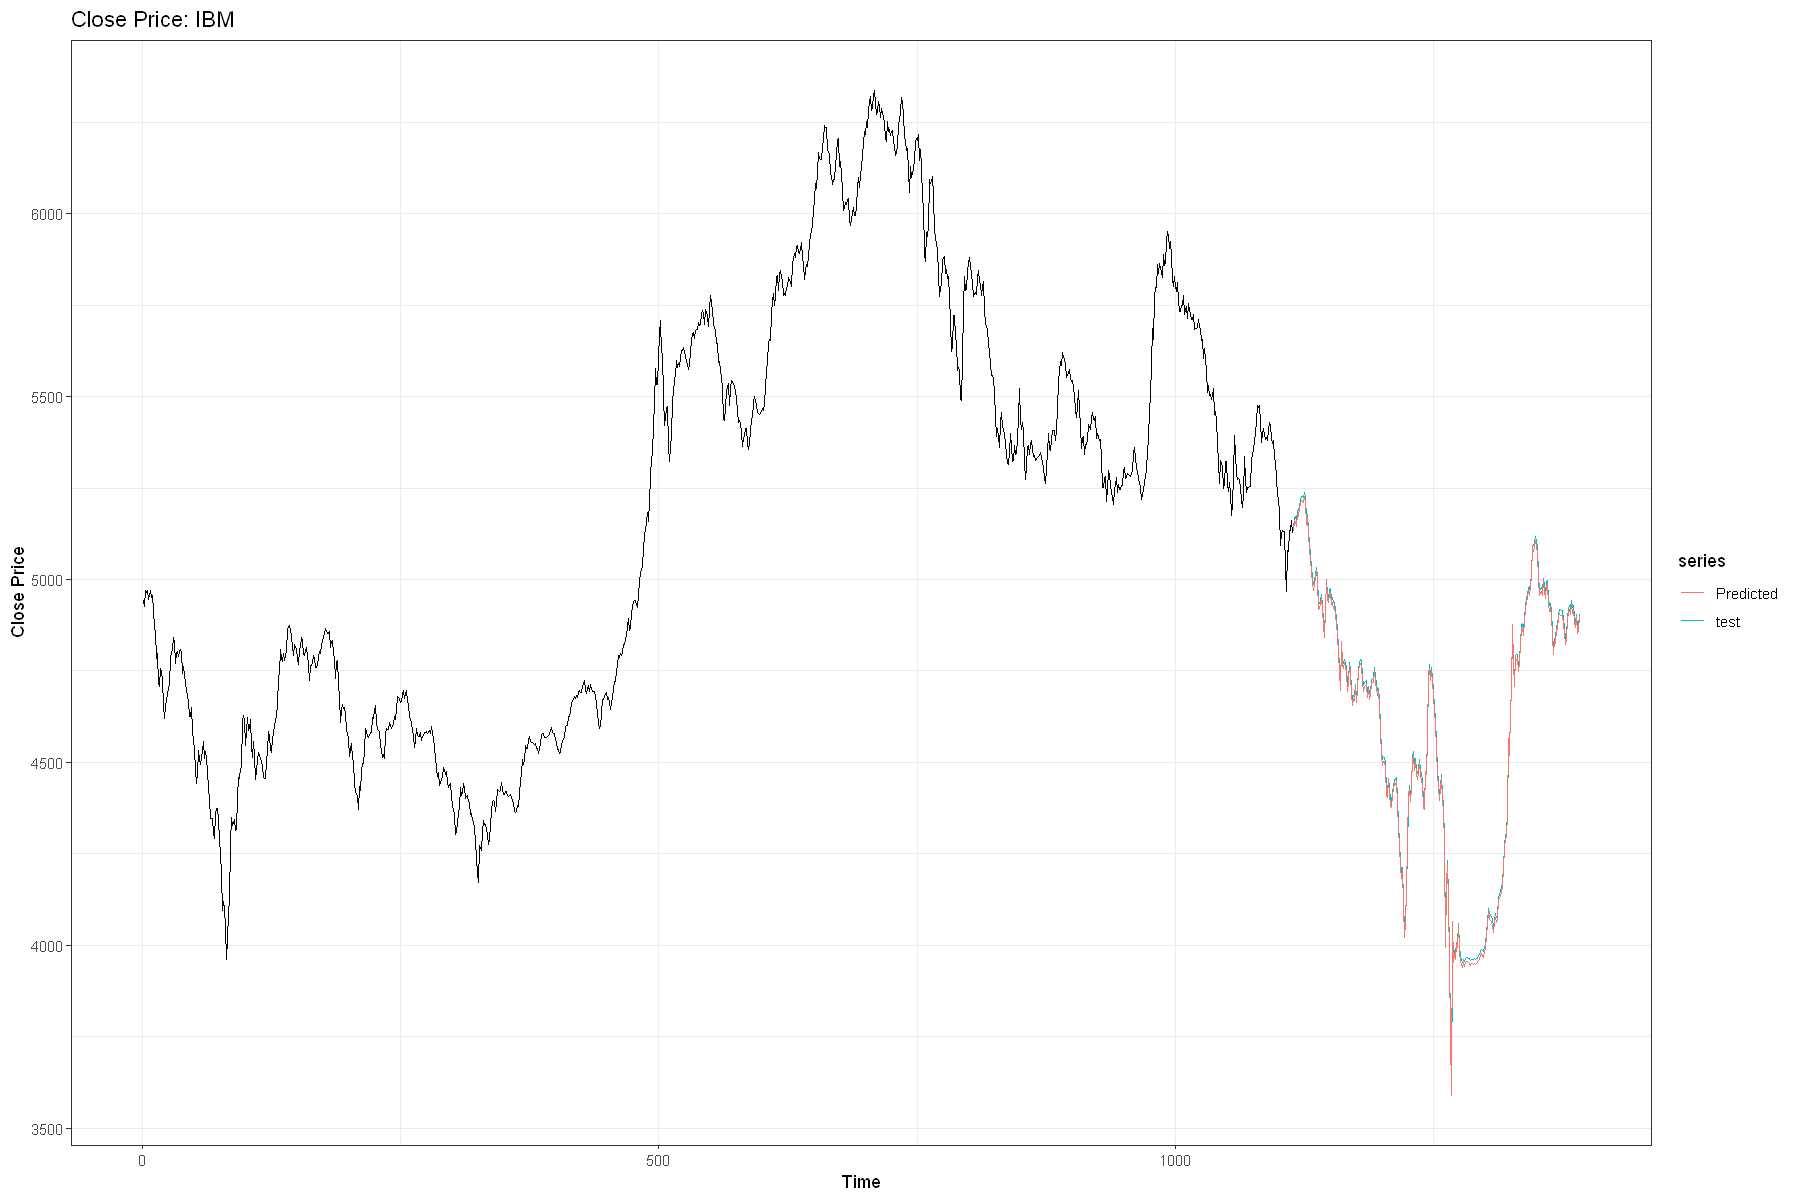

In [127]:
#Plotting training, test and predicted data sets side by side.
Predicted.ts <- ts(test.Series[,2], start = n+1, end = N)
autoplot(DSE.train.ts) +
autolayer(DSE.test.ts, series="test") +
autolayer(Predicted.ts, series="Predicted") +
xlab("Time") +
ylab("Close Price") +
ggtitle("Close Price: IBM") +
theme_bw()

In [128]:
# Calculate meaningful results.
Y_test <- test.Series$Close
residuals <- test.Series$Residual
# Procedure to calculate RMSE.
RMSE <- sqrt(mean(residuals^2))
y_test_mean = mean(Y_test)
# Calculate total sum of squares
tss = sum((Y_test - y_test_mean)^2 )
# Calculate residual sum of squares
rss = sum(residuals^2)
# Calculate R-squared
rsq = 1 - (rss/tss)
# Rounding
RMSE <- round(RMSE,4)
rsq <- round(rsq,4)
paste0("R-Squared Value: ", rsq)
paste0("RMSE: ", RMSE)

[1] "R-Squared Value: 0.9987"

[1] "RMSE: 13.8802"

#### **Conclusion**

An R-squared value of 99% and low RMSE indicates the model is a very good predictor of DSEX indices. While in aggregate it seemed that the LSTM is effective at predicting the next day values, in reality the prediction made for the next day is very close to the actual value of the previous day. This can be seen below, which shows the actual prices lagged by 1 day compared to the predicted price.

These results imply that LSTM is not able to predict the value for the next day in the stock market. In fact, the best guess the model can make is a value almost identical to the current day’s price.

In [129]:
#Create lag t-1
DSE.test.ts1<-shift(DSE.test.ts, n=1, fill=0, type="lead")


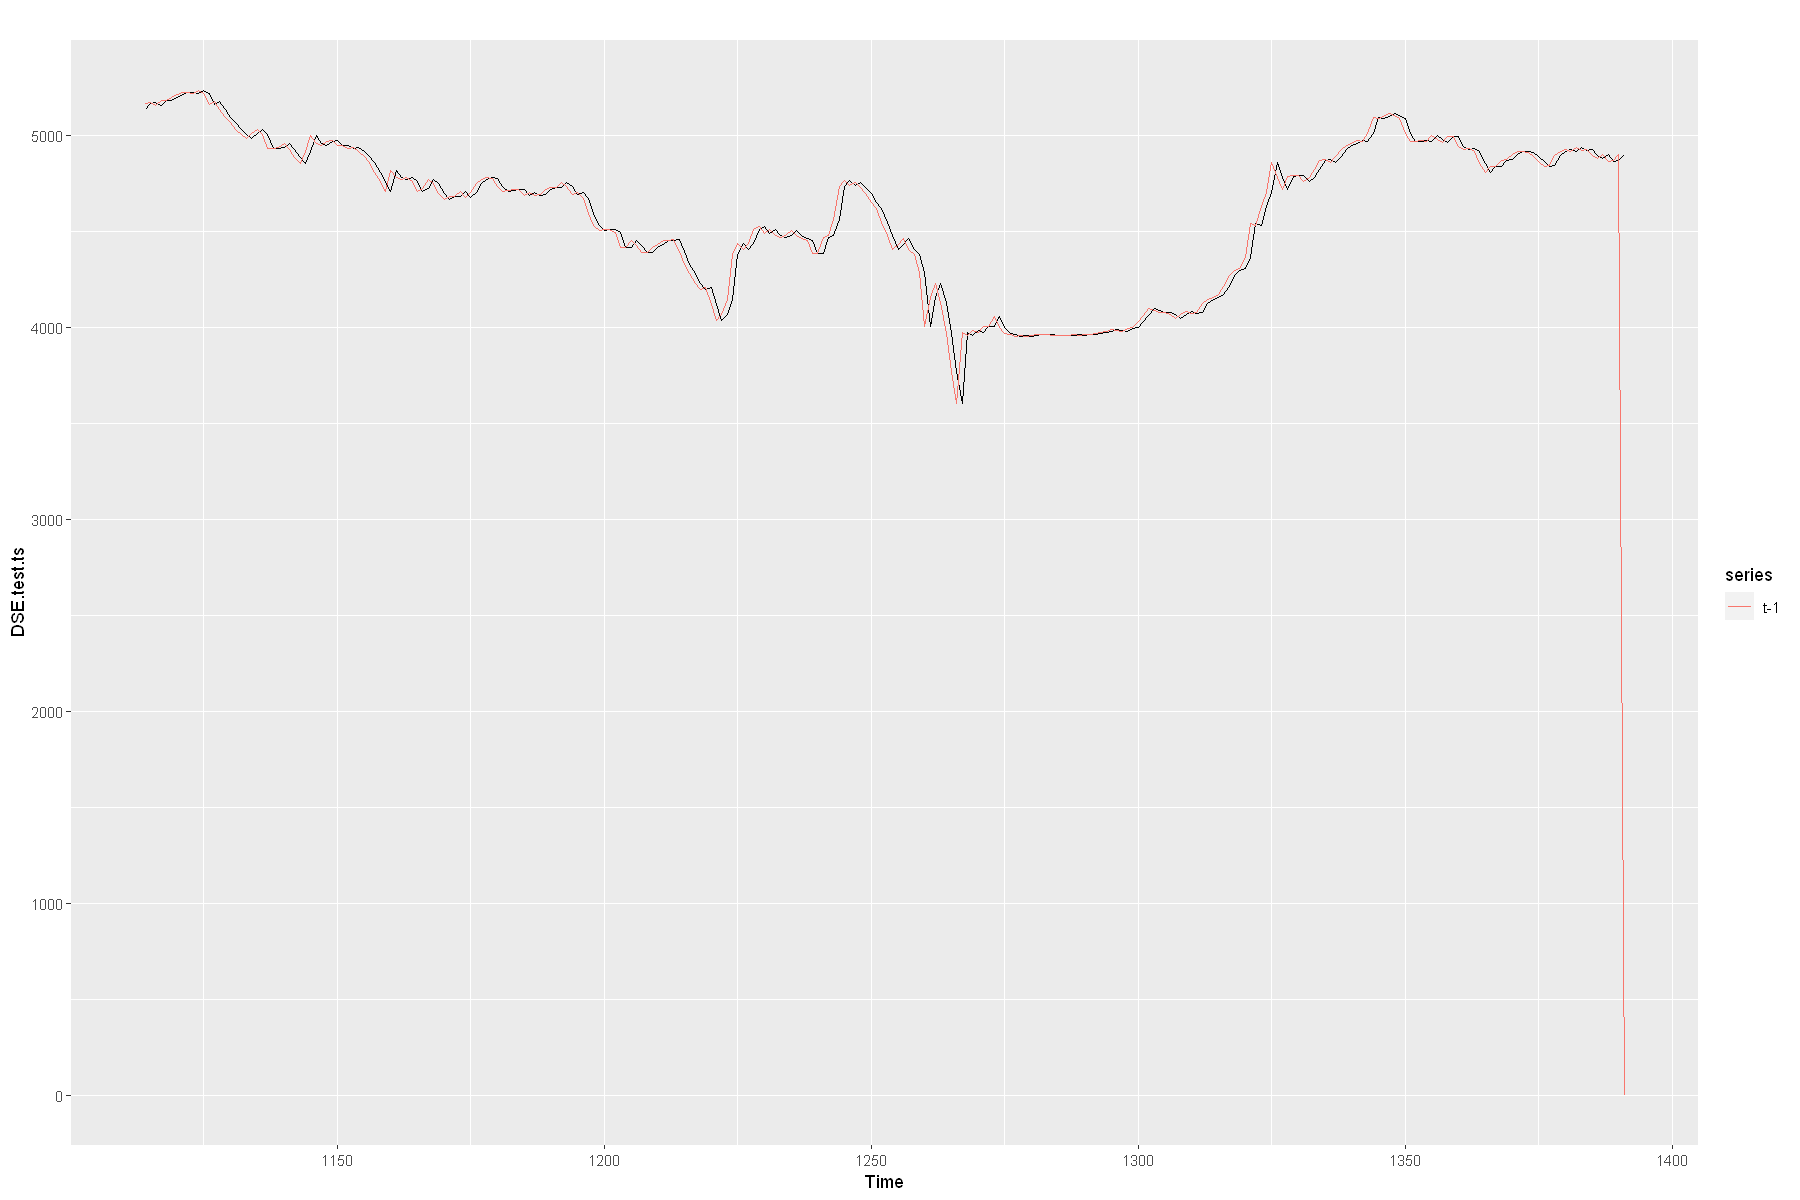

In [130]:
#Plot the two series
autoplot(DSE.test.ts)+
autolayer(DSE.test.ts1, series="t-1") 


#### *References:*

Ding, G., Qin, L. Study on the prediction of stock price based on the associated network model of LSTM. Int. J. Mach. Learn. & Cyber. 11, 1307–1317 (2020). https://doi.org/10.1007/s13042-019-01041-1

TimeSeries Forecasting using LSTM in r http://rwanjohi.rbind.io/2018/04/05/time-series-forecasting-using-lstm-in-r/

TS Exploration https://afit-r.github.io/ts_exploration

Machine Learning in Finance: Why You Should Not Use LSTM’s to Predict the Stock Market https://www.blueskycapitalmanagement.com/machine-learning-in-finance-why-you-should-not-use-lstms-to-predict-the-stock-market/
